In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_score, roc_auc_score, 
                             roc_curve)

# Quiet setting warnings
pd.options.mode.chained_assignment = None

# Background

The Departments of Neurology and Neurosurgery would like to study the possibility of predicting which of their patients is at risk of presenting a brain stroke. Since it is known that several factors such as smoking, hypertension or obesity are related to an increased risk of stroke, they designed a multi-institutional study collecting that information from a large number of patients who were followed up to record whether they had a stroke or not.

# Goals

- To identify if the risk of stroke can be identified using the collected dataset.  

- Build and evaluate the performance of: a random forest classifier, a linear support vector machine classifier, and a logistic regression classifier. Feel free to evaluate non-linear support vector machines if curious.  

- Discuss the similarities and differences between the performance of the three trained classifiers in terms of ROC curve analysis and the distributions of their probabilistic predictions.  

- Explain which approach you would deploy clinically and justify the reasons for it.  

In [212]:
# Set wkdir
WORK_DIR = os.getcwd()

# Import and display data
data = pd.read_csv(f'{WORK_DIR}/brain_stroke.csv')
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


# Functions

Below are some functions I'll use for processing/visualizing the data.

In [213]:
def X_y_split(df, target: str, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y
    

def numFeature_distribution(df, n_col, bins, width, height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numFeatures = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('default')
    n_row = int(np.ceil(len(numFeatures)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(width, height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions
    for i, feature in enumerate(numFeatures):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=bins)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    # Remove subplots with no feature to plot
    rm_count = len(plots) - len(numFeatures)
    if rm_count:
        rm_axes = plots[-rm_count:]
        for plot in rm_axes:
            fig.delaxes(plot)
        
    plt.show()
        

def catFeature_balance(df, n_col: int, width: float, height: float, hspace: float, wspace: float):
    '''
    Function to plot the balance of each categorical feature in a data frame
    '''
    
    # Set figure space
    plt.style.use('default')
    catFeatures = df.columns
    n_row = int(np.ceil(len(catFeatures)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(width, height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    if len(catFeatures) > 1:
        for ax in axs:
            try:
                for plot in ax:
                    plots.append(plot)
            except:
                plots.append(ax)
    else:
        plots.append(axs)

    # Plot distributions
    for i, feature in enumerate(catFeatures):
        
        # Set count df for plot
        labels = list(set(df[feature]))
        counts = [list(df[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({
            'labels': [str(label) if label is not np.nan else "Missing" for label in labels], 
            'counts': counts
        })
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue", edgecolor = "black")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    # Remove subplots with no feature to plot
    rm_count = len(plots) - len(catFeatures)
    if rm_count:
        rm_axes = plots[-rm_count:]
        for plot in rm_axes:
            fig.delaxes(plot)
        
    plt.show()
    

def correlation_plot(X, width: float, height: float):
    '''
    Function to generate correlation plot
    Source for correlation plot style: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    '''
    
    # Compute the correlation matrix
    corr = X.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(width, height))

    # Draw the heatmap with the mask and correct aspect ratio
    plt.style.use('default')
    cmap = sns.diverging_palette(220, 20, s=60)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, 
                annot=True, linewidths=1, cbar_kws={"shrink": .5})
    ax.set_title('Correlation Plot of Numeric Features', size=14)
    plt.show()    
    

def encodeCategories(X, drop: bool):
    '''
    Function to encode categorical features
    Features with two categories will be encoded as binary
    Features with more than two categories will be one-hot-encoded
    '''
    # Copy df 
    df = X.copy()
    categorialColumnNames_list = df.select_dtypes(include=['object']).columns.values.tolist()
    featureCategoryCount_dict = {feature: len(set(df[feature])) for feature in categorialColumnNames_list}
    
    # Display message
    print('Encoding categorical features...\n')
    
    # Encode feature based on number of categories
    for feature, categoryCount in featureCategoryCount_dict.items():

        # Convert binary feature to binary 0, 1
        if categoryCount == 2:

            # Encode column
            feat0, feat1 = sorted(list(set(df[feature])))
            df[feature] = df[feature].map({feat0: 0.0, feat1: 1.0})

            # Display which category is encoded 0 and 1
            print(feature + ' encoded as binary')
            print(f'   0: {feat0}')
            print(f'   1: {feat1}\n')

        # One-hot-encode feature with more than 2 categories
        elif categoryCount > 2:

            # Code adapted from Antonio Perez, PhD
            # Encode column
            if drop:
                encoder = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)
            else:
                encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
            encoder.fit(df[feature].to_numpy().reshape(-1, 1))
            encodedData = encoder.transform(df[feature].to_numpy().reshape(-1, 1))

            # Copy to data frame
            for i in range(encodedData.shape[1]):
                if type(encoder.categories_[0][i]) == str:
                    df[f'{feature}_{encoder.categories_[0][i]}'] = encodedData[:, i]

            # Drop original column
            df.pop(feature)

            # Display message
            print(f'{feature} one-hot-encoded\n')

        # Safe gaurd against features with only one category
        else:
            pass
        
    return df
    
    

# EDA
## Missing Data

In [214]:
# View missing data for 50 sample set - no missing data
print('Missing Data:')
print(data.isnull().sum())

Missing Data:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


## Visualizing Target & Feature Balance/Distributions

In [215]:
# Split into target/features
X, y = X_y_split(data, target='stroke', to_numpy=False)

# Split features in numeric/categorical sets
numFeatures = ['age', 'avg_glucose_level', 'bmi']
catFeatures = [feat for feat in X.columns if feat not in numFeatures]
X_numDF = X[numFeatures]
X_catDF = X[catFeatures]

### Numeric Features

BMI has an approximate Gaussian distribution. Age and average glucose level clearly have non-normal distributions.

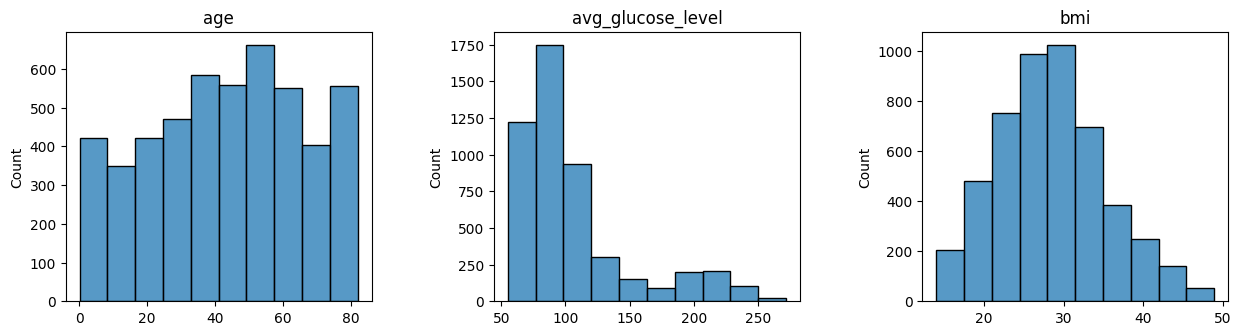

In [216]:
# Plot distributions
numFeature_distribution(df=X_numDF, n_col=3, width=15, height=3.5, bins=10, hspace=0.3, wspace=0.4)

### Categorical Features

Some heavy class imbalance exists for a few key predictors, esp. hypertension and heart disease.

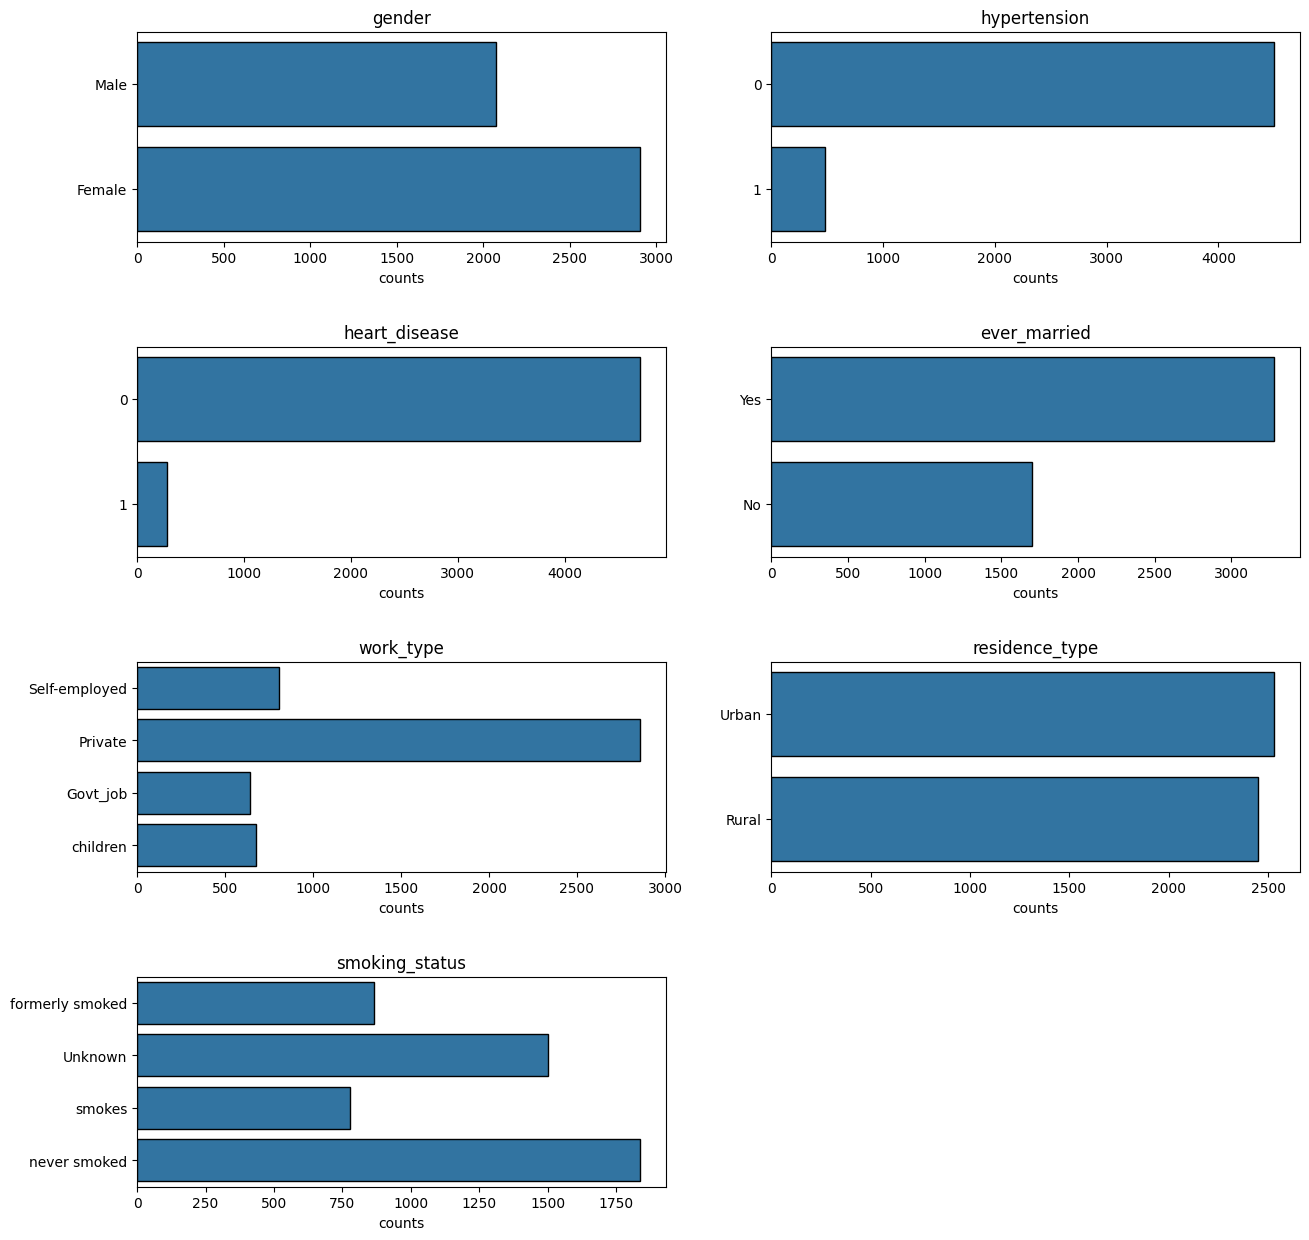

In [217]:
# Convert binary variables to categorical for plot
X_catDF['hypertension'] = X_catDF['hypertension'].astype('object')
X_catDF['heart_disease'] = X_catDF['heart_disease'].astype('object')
X_catDF.dtypes

# Plot class balances
catFeature_balance(df=X_catDF, n_col=2, width=15, height=15, hspace=0.5, wspace=0.2)

### Target Class Balance

Again, the target is quite imbalanced. We will keep this in mind during model construction/selection/performance evaluation.

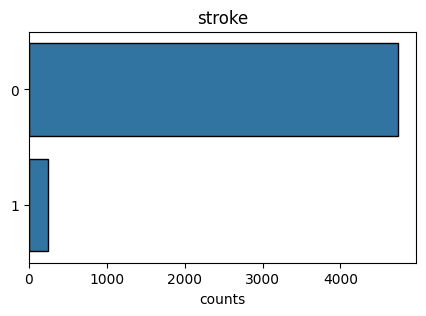

In [218]:
# Convert pandas series to df and data type to object
y_DF = y.to_frame()
y_DF['stroke'] = y_DF['stroke'].astype('object')

# Plot
catFeature_balance(df=y_DF, n_col=1, width=5, height=3, hspace=0, wspace=0)

### Correlation Plot of Numeric Features

There are no obvious correlations among the numeric features that seem to be problematic.

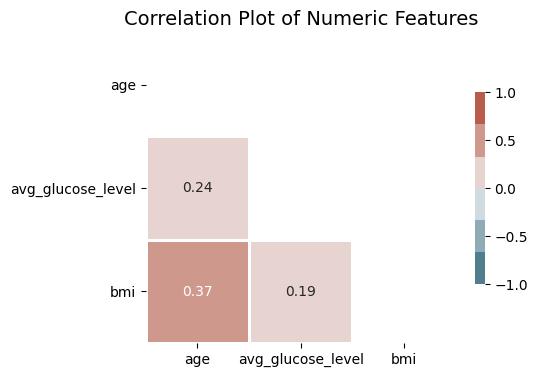

In [186]:
correlation_plot(X=X_numDF, width=5, height=5)

# Data Pre-Processing

## Encode Categorical Features

In [225]:
X_encodedDF = encodeCategories(X_catDF, drop=False)
X_encodedDF.columns = X_encodedDF.columns.str.lower().str.replace(' ', '_')
X_encodedDF.head(5)

Encoding categorical features...

gender encoded as binary
   0: Female
   1: Male

hypertension encoded as binary
   0: 0
   1: 1

heart_disease encoded as binary
   0: 0
   1: 1

ever_married encoded as binary
   0: No
   1: Yes

work_type one-hot-encoded

residence_type encoded as binary
   0: Rural
   1: Urban

smoking_status one-hot-encoded



,gender,hypertension,heart_disease,ever_married,residence_type,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [261]:
# Merge categorical data with numeric features
# NOTE: We'll need to standardize our numeric features. This will be done in the cross-validation process, however.
X_model = pd.concat([X_numDF, X_encodedDF], axis=1)

# Get feature information
# These are column indices for numeric features; need indices and not names for subsetting numpy matrices
numFeaturesIdx = [X_model.columns.get_loc(column) for column in X_numDF.columns if column in X_numDF.columns]
featureNames = X_model.columns

# Building Classifiers: Random Forest, Linear SVM & Logistic Regression

Here we will build and evaluate the performance of a random forest classifier, a linear SVM classifier, and a logistic regression classifier. We will use stratified k-fold cross validation here with a fixed k=10. Typically we'd likely want to include some sort of hyperparameter tuning for each model. For the sake of this assignment we'll just 

In [358]:
def scaleNoLeak(X_train, X_test, numFeaturesIdx: list):
    '''
    Function to scale numeric features in training and test sets
    Scaler is trained on the training set and then applied to the test set to prevent leak into test set
    numFeaturesIdx is a list containing the indices of numeric columns
    '''
    
    # Extract numeric features from each set to standardize; don't want to include categorical features in this step
    X_trainNum = X_train[:, numFeaturesIdx]
    X_testNum = X_test[:, numFeaturesIdx]
    
    # Standardize features - train scalar on train set (hold out test set) to prevent test set leak
    scaler = StandardScaler()                           # Initialize scaler
    X_trainNumScaled = scaler.fit_transform(X_trainNum) # Train scalar on training set and tranform training set
    X_testNumScaled = scaler.transform(X_testNum)       # Transform test set using fit from training set
    
    # Replace non-standardized features with standardized features
    X_train[:, numFeaturesIdx] = X_trainNumScaled
    X_test[:, numFeaturesIdx] = X_testNumScaled
    
    # Return standardized data set
    return X_train, X_test


def clf_perfEval(y_true, y_pred, y_score, roc_label):
    '''
    Function to evaluate performance of Logistic Regression (or any binary) classifier
    
    Inputs:
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained model)
        y_score: Target scores (probability estimates of the positive class)
        
    Outputs:
        Classification report
        ROC curve with AUC score reported
    '''
    
    # Performance evaluation
    print(classification_report(y_true, y_pred))

    # ROC, AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)    
    
    # ROC Curve
    #plt.figure()
    plt.plot(fpr, tpr, marker='.', label=f'{roc_label} (AUC = {round(auc, 3)})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    #plt.show()
    
    

In [368]:
# Initialize stratified k-fold cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Initialize data frames to store classifier results
clf_pred_DF = pd.DataFrame()

# Classifier implementations on each split
for train_index, test_index in kfold.split(X_model.to_numpy(), y.to_numpy()):
    
    # Split data into train/test sets
    X_train, X_test = X_model.to_numpy()[train_index], X_model.to_numpy()[test_index]
    y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
    
    # Standardize data
    X_train, X_test = scaleNoLeak(X_train=X_train, X_test=X_test, numFeaturesIdx=numFeaturesIdx)
    
    # Random forest implementation
    clf_RF = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1, class_weight='balanced')
    clf_RF.fit(X_train, y_train)
    y_pred_RF = clf_RF.predict(X_test)
    y_prob_RF = clf_RF.predict_proba(X_test)[:,1]
    
    # Linear SVM implementation
    #svm = LinearSVC(C=1, loss='hinge', dual=False, random_state=1, class_weight='balanced')
    #clf_linSVM = CalibratedClassifierCV(svm)
    svm = SVC(kernel='linear', random_state=1, class_weight='balanced')
    clf_linSVM = CalibratedClassifierCV(svm) # This function is used to get y_score (call .predict_proba() method)
    clf_linSVM.fit(X_train, y_train)
    y_pred_linSVM = clf_linSVM.predict(X_test)
    y_prob_linSVM = clf_linSVM.predict_proba(X_test)[:,1]
    
    # Logistic regression implementation
    clf_logReg = LogisticRegression(class_weight='balanced')
    clf_logReg.fit(X_train, y_train)
    y_pred_logReg = clf_logReg.predict(X_test)
    y_prob_logReg = clf_logReg.predict_proba(X_test)[:,1]
    
    # Store predictions from all classifiers in a data frame
    prediction_results = pd.DataFrame({
        'y_true': y_test,
        'y_pred_RF': y_pred_RF,
        'y_prob_RF': y_prob_RF,
        'y_pred_linSVM': y_pred_linSVM,
        'y_prob_linSVM': y_prob_linSVM,
        'y_pred_logReg': y_pred_logReg,
        'y_prob_logReg': y_prob_logReg
    })
    
    # Append results from each split to clf_pred_DF
    clf_pred_DF = pd.concat([clf_pred_DF, prediction_results])
    

In [369]:
clf_pred_DF.head(5)

,y_true,y_pred_RF,y_prob_RF,y_pred_linSVM,y_prob_linSVM,y_pred_logReg,y_prob_logReg
0,1,0,0.106,0,0.083902,1,0.603221
1,1,0,0.172,0,0.232068,1,0.895005
2,1,0,0.002,0,0.020912,0,0.267077
3,1,0,0.016,0,0.040914,0,0.440128
4,1,0,0.450,0,0.147425,1,0.830863


In [370]:
clf_pred_DICT = {
    'Random Forest': {
        'y_pred': clf_pred_DF.y_pred_RF,
        'y_score': clf_pred_DF.y_prob_RF
    },
    'Linear SVM': {
        'y_pred': clf_pred_DF.y_pred_linSVM,
        'y_score': clf_pred_DF.y_prob_linSVM
    },
    'Logistic Regression': {
        'y_pred': clf_pred_DF.y_pred_logReg,
        'y_score': clf_pred_DF.y_prob_logReg
    },
}

In [371]:
print("Actual values:\n")
print(clf_pred_DF['y_true'].value_counts())

print("\nRF:\n")
print(clf_pred_DF['y_pred_RF'].value_counts())

print("\nlinSVM:\n")
print(clf_pred_DF['y_pred_linSVM'].value_counts())

print("\nLogReg:\n")
print(clf_pred_DF['y_pred_logReg'].value_counts())

Actual values:

0    4733
1     248
Name: y_true, dtype: int64

RF:

0    4978
1       3
Name: y_pred_RF, dtype: int64

linSVM:

0    4981
Name: y_pred_linSVM, dtype: int64

LogReg:

0    3516
1    1465
Name: y_pred_logReg, dtype: int64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

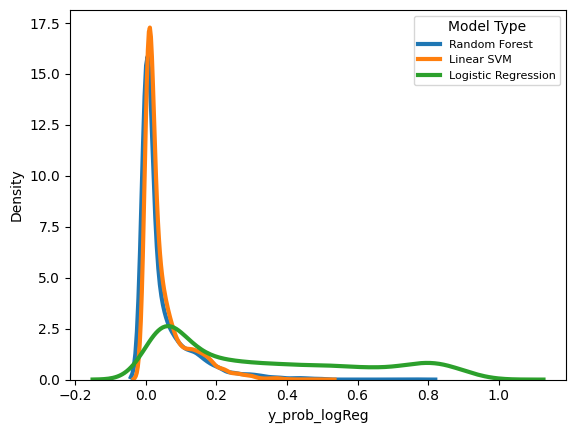

In [380]:
# Print performance metrics and ROC curve for each model type
for model in ['Random Forest', 'Linear SVM', 'Logistic Regression']:    
    sns.distplot(clf_pred_DICT[model]['y_score'], hist=False, kde=True, kde_kws={'linewidth': 3}, label=model)
    plt.legend(prop={'size': 8}, title = 'Model Type')
    

Random Forest

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4733
           1       0.00      0.00      0.00       248

    accuracy                           0.95      4981
   macro avg       0.48      0.50      0.49      4981
weighted avg       0.90      0.95      0.93      4981

Linear SVM

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4733
           1       0.00      0.00      0.00       248

    accuracy                           0.95      4981
   macro avg       0.48      0.50      0.49      4981
weighted avg       0.90      0.95      0.93      4981

Logistic Regression

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      4733
           1       0.14      0.81      0.23       248

    accuracy                           0.74      4981
   macro avg       0.56      0.77      0.54      4981
weighted avg       0.94   

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


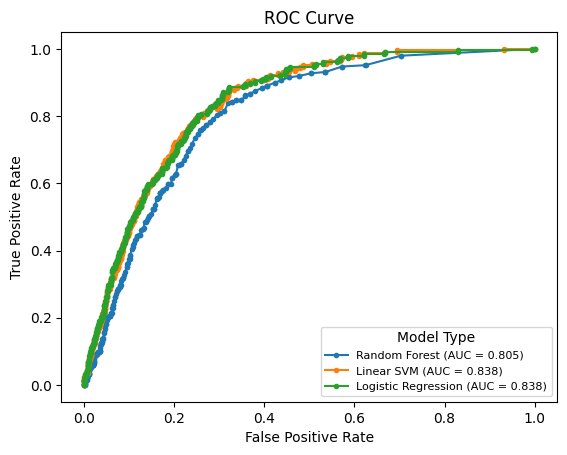

In [379]:
# Print performance metrics and ROC curve for each model type
for model in ['Random Forest', 'Linear SVM', 'Logistic Regression']:    
    print(model + '\n')
    clf_perfEval(
        y_true=clf_pred_DF.y_true, 
        y_pred=clf_pred_DICT[model]['y_pred'], 
        y_score=clf_pred_DICT[model]['y_score'], 
        roc_label=model
    )
    plt.legend(prop={'size': 8}, title = 'Model Type')
    

In [321]:
# Notes
# Random forest doesn't usually require standardizing
# Check out pipeline
# Considerations of imbalanced classes 